In [2]:
import sys
#sys.path.append("/Users/hooshang/Desktop/hooshang")

import numpy as np
import matplotlib.pyplot as plt
import SOMPY as sompy
import astropy.io.fits as pyfits
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import multiprocessing


cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)


Reading in BC03 models

In [3]:
redshift=1.0
catal=np.genfromtxt('sedlist/All_mags_z1.0.cat',dtype=[('names', 'S50'), ('u', 'f8'), ('b', 'f8'), ('v', 'f8'), ('r', 'f8'),('i', 'f8'), ('z', 'f8'), ('y', 'f8'), ('j', 'f8'), ('h', 'f8'), ('k', 'f8'),('ch1', 'f8'), ('ch2', 'f8'), ('ch3', 'f8'), ('ch4', 'f8')])
    

ub=(catal['u']-catal['b'])
bv=(catal['b']-catal['v'])
vr=(catal['v']-catal['r'])
ri=(catal['r']-catal['i'])
iz=(catal['i']-catal['z'])
zy=(catal['z']-catal['y'])
yj=(catal['y']-catal['j'])
jh=(catal['j']-catal['h'])
hk=(catal['h']-catal['k'])
kc1=(catal['k']-catal['ch1'])
c1c2=(catal['ch1']-catal['ch2'])
c2c3=(catal['ch2']-catal['ch3'])
c3c4=(catal['ch3']-catal['ch4'])

ageo=[]
for bbb in range(len(catal['names'])):
    ageo.append(float(catal['names'][bbb][9:15]))
ageo=np.array(ageo)
selage=(ageo<=cosmo.age(redshift).value) 


def bordare_rang(redshift):
    catal=np.genfromtxt('sedlist/All_mags_z1.0.cat',dtype=[('names', 'S50'), ('u', 'f8'), ('b', 'f8'), ('v', 'f8'), ('r', 'f8'),('i', 'f8'), ('z', 'f8'), ('y', 'f8'), ('j', 'f8'), ('h', 'f8'), ('k', 'f8'),('ch1', 'f8'), ('ch2', 'f8'), ('ch3', 'f8'), ('ch4', 'f8')])
    mass=np.genfromtxt('Mass_table_fromcsp.cat')
    met,age,tau,ebv,ml=np.zeros_like(catal['b']),np.zeros_like(catal['b']),np.zeros_like(catal['b']),np.zeros_like(catal['b']),np.zeros_like(catal['b']),
    uvj=np.zeros_like(catal['names'])
    for i in range(len(catal['names'])):
        met[i]=int(catal['names'][i][28:30])
        age[i]=float(catal['names'][i][9:15])
        tau[i]=float(catal['names'][i][19:24])
        ebv[i]=float(catal['names'][i][34:38])
        inja=(np.abs(mass[:,0]-tau[i])<=0.01)&(np.abs(mass[:,2]-(np.log10(10.0**9.0*np.float(age[i])))<=0.01))
        ml[i]=(np.median(mass[inja,7])) 
        if ~(((catal['r'][i]-catal['j'][i])>0.8*(catal['j'][i]-catal['k'][i])+0.7)&((catal['r'][i]-catal['j'][i])>1.3)&((catal['j'][i]-catal['k'][i])<1.5))&((catal['r'][i]-catal['j'][i])<1.5):
            uvj[i]='sb'
        elif ~(((catal['r'][i]-catal['j'][i])>0.8*(catal['j'][i]-catal['k'][i])+0.7)&((catal['r'][i]-catal['j'][i])>1.3)&((catal['j'][i]-catal['k'][i])<1.5))&((catal['r'][i]-catal['j'][i])>=1.5):
            uvj[i]='sd'
        else:
            uvj[i]='qg'

    ub=(catal['u']-catal['b'])
    bv=(catal['b']-catal['v'])
    vr=(catal['v']-catal['r'])
    ri=(catal['r']-catal['i'])
    iz=(catal['i']-catal['z'])
    zy=(catal['z']-catal['y'])
    yj=(catal['y']-catal['j'])
    jh=(catal['j']-catal['h'])
    hk=(catal['h']-catal['k'])
    kc1=(catal['k']-catal['ch1'])
    c1c2=(catal['ch1']-catal['ch2'])
#    c2c3=(catal['ch2']-catal['ch3'])
#    c3c4=(catal['ch3']-catal['ch4'])
#&(ebv<=0.7)&(~((age>1.0)&(tau<1.5)))
    selage=(age<=cosmo.age(redshift).value)&(~np.isnan(ub))&(~np.isnan(bv))&(~np.isnan(vr))&(~np.isnan(ri))&(~np.isnan(iz))&(~np.isnan(zy))&(~np.isnan(yj))&(~np.isnan(jh))&(~np.isnan(hk))&(~np.isnan(kc1))&(~np.isnan(c1c2))
    dat=np.array([ub[selage],bv[selage],vr[selage],ri[selage],iz[selage],zy[selage],yj[selage],jh[selage],hk[selage],kc1[selage],c1c2[selage]])
    data=dat.T
    par=[met[selage],age[selage],tau[selage],ebv[selage],catal['ch2'][selage],uvj[selage]]
    return data,par

data,par=bordare_rang(redshift)
print (np.shape(data))

(13776, 11)


Training a som with model SEDs

In [4]:
msz0 = 80
msz1 = 60
sm = sompy.SOMFactory.build(data, mapsize=[msz0,msz1], mapshape='planar', lattice='rect', initialization='pca') 
sm.train(n_job=4, shared_memory = 'no')

 Training...
 pca_linear_initialization took: 0.090000 seconds
 Rough training...
 radius_ini: 10.000000 , radius_final: 2.500000, trainlen: 11

 epoch: 1 ---> elapsed time:  5.785000, quantization error: 0.566656

 epoch: 2 ---> elapsed time:  1.966000, quantization error: 0.349187

 epoch: 3 ---> elapsed time:  0.824000, quantization error: 0.261534

 epoch: 4 ---> elapsed time:  0.801000, quantization error: 0.248670

 epoch: 5 ---> elapsed time:  0.853000, quantization error: 0.233962

 epoch: 6 ---> elapsed time:  0.719000, quantization error: 0.215724

 epoch: 7 ---> elapsed time:  0.891000, quantization error: 0.196221

 epoch: 8 ---> elapsed time:  0.746000, quantization error: 0.175656

 epoch: 9 ---> elapsed time:  0.929000, quantization error: 0.154962

 epoch: 10 ---> elapsed time:  0.708000, quantization error: 0.134837

 epoch: 11 ---> elapsed time:  0.771000, quantization error: 0.116643

 Finetune training...
 radius_ini: 2.500000 , radius_final: 1.000000, trainlen: 14


Reading in COSMOS data and generating many realizations of a SED shape to be mapped to the SOM

In [5]:
ndtype=[('id', "S15"), ('ra', float), ('dec', float),('ubc',float), ('bvc',float),('vrc',float), ('ric',float), 
        ('izc',float), ('zyc',float), ('yjc',float), ('jhc',float), ('hkc',float),('k1c',float), ('c12c',float),
        ('c23c',float),('c34c',float),('eub',float), ('ebv',float),('evr',float), ('eri',float), 
        ('eiz',float), ('ezy',float), ('eyj',float), ('ejh',float), ('ehk',float),('ekc',float), ('ec12',float),
        ('ec23',float),('ec34',float),('zc',float), ('massc',float), ('sfrc',float), ('agec',float), 
        ('ebvc',float), ('kmag',float),('ekmag',float), ('MU',float),('MV',float), ('MJ',float), ('overdensity',float),('env', "S15")]

cosmos=np.genfromtxt('cosmos_z1_color+env.cat',dtype=ndtype)

mub,mbv,mvr,mri,miz,mzy,myj,mjh,mhk,mk1,mc12=1.0,1.2,1.4,1.6,1.1,1.4,2.0,1.5,1.6,1.2,0.85
cub,cbv,cvr,cri,ciz,czy,cyj,cjh,chk,ck1,cc12=0.2,-0.4,0.1,-0.3,0.1,0.1,-0.2,0.2,-0.2,0.1,0.04

ubc=mub*np.array(cosmos['ubc'])+cub
bvc=mbv*np.array(cosmos['bvc'])+cbv
vrc=mvr*np.array(cosmos['vrc'])+cvr
ric=mri*np.array(cosmos['ric'])+cri
izc=miz*np.array(cosmos['izc'])+ciz
zyc=mzy*np.array(cosmos['zyc'])+czy
yjc=myj*np.array(cosmos['yjc'])+cyj
jhc=mjh*np.array(cosmos['jhc'])+cjh
hkc=mhk*np.array(cosmos['hkc'])+chk
k1c=mk1*np.array(cosmos['k1c'])+ck1
c12c=mc12*np.array(cosmos['c12c'])+cc12
eub=np.array(cosmos['eub'])
ebv=np.array(cosmos['ebv'])
evr=np.array(cosmos['evr'])
eri=np.array(cosmos['eri'])
eiz=np.array(cosmos['eiz'])
ezy=np.array(cosmos['ezy'])
eyj=np.array(cosmos['eyj'])
ejh=np.array(cosmos['ejh'])
ehk=np.array(cosmos['ehk'])
ekc=np.array(cosmos['ekc'])
ec12=np.array(cosmos['ec12'])

In [7]:
import time

def err_gen2(iii=9):
    num=1
    color=np.array([ubc[iii],bvc[iii],vrc[iii],ric[iii],izc[iii],zyc[iii],yjc[iii],jhc[iii],hkc[iii],k1c[iii],c12c[iii]])
    colerr=np.array([eub[iii],ebv[iii],evr[iii],eri[iii],eiz[iii],ezy[iii],eyj[iii],ejh[iii],ehk[iii],ekc[iii],ec12[iii]])
    newcol=np.zeros([num,len(color)])
    for j in range(num):
        for i in range(len(color)):
            newcol[j,i]=np.random.normal(color[i],colerr[i],1)
    
    dat2=np.array([newcol[:,0],newcol[:,1],newcol[:,2],newcol[:,3],newcol[:,4],newcol[:,5],newcol[:,6],newcol[:,7],
             newcol[:,8],newcol[:,9],newcol[:,10]])
    da=dat2.T
    ac=sm.bmu_ind_to_xy(sm.project_data(da))
    return ac
def work(j):
    err_gen2(iii=9)


In [25]:
number =10**5

In [26]:
%%time
y=[]
for num in range(number):
    y.append(err_gen2(iii=9))


CPU times: user 7min 30s, sys: 3.02 s, total: 7min 33s
Wall time: 7min 35s


In [27]:
%%time

for j in range(number):
    p = multiprocessing.Process(target = work, args = (j, ))
    p.start()


CPU times: user 2min, sys: 4min 24s, total: 6min 25s
Wall time: 1d 14h 7min


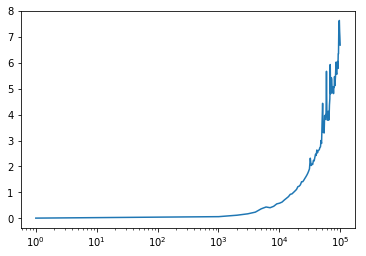

In [24]:

x=[10,100,1000,10000,100000]
y=[0.06,0.467,4.54,46.8,] # CPU singlecore
y2=[0.047,0.319,3.74,40.4,]# CPU quadcore
y3=y2/10#[0.047,0.319,3.74,40.4,]# CPU quadcore


plt.plot(x,y,label='1 core CPU')
plt.plot(x,y2,label='4 core CPU')
plt.plot(x,y3,label='GPU')
plt.legend(loc=2)
plt.xscale('log')
plt.savefig('')

In [5]:
import umap


In [71]:
%time embedding = umap.UMAP(n_neighbors=300, min_dist=1, metric='euclidean').fit_transform(data)


CPU times: user 42.8 s, sys: 1.73 s, total: 44.5 s
Wall time: 43.6 s


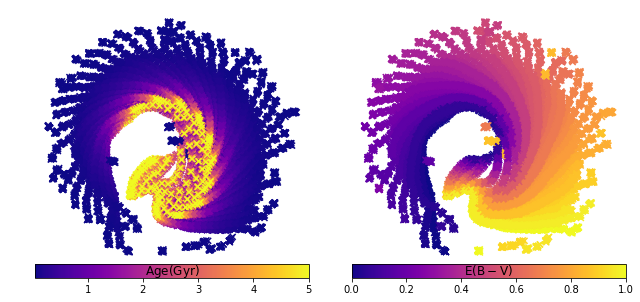

In [72]:
#par=[met[selage],age[selage],tau[selage],ebv[selage],catal['ch2'][selage],uvj[selage]]

plt.figure(figsize=(9,4.5))
plt.subplot(1,2,1)
cf=plt.scatter(embedding[:,0],embedding[:,1],c=par[1],cmap='plasma',label='age',marker='x')
cb = plt.colorbar(orientation="horizontal", pad=0)
cb.set_label(r'$\rm Age (Gyr)$', labelpad=-32,size=12)
plt.axis('off')

plt.subplot(1,2,2)
cf=plt.scatter(embedding[:,0],embedding[:,1],c=par[3],cmap='plasma',label='ebv',marker='x')
cb = plt.colorbar(orientation="horizontal", pad=0)
cb.set_label(r'$\rm E(B-V)$', labelpad=-32,size=12)

plt.axis('off')


plt.tight_layout()
plt.savefig('umap_bc03.png')